In [1]:
import sys 
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../')
import warnings
import seaborn as sns
# To suppress all warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import  r2_score as r2
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

/home/anto/Softwares/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
%load_ext autoreload
%autoreload 2
from database import Magneticum
from relation import Scaling
from relation import Distribution
from relation import Analysis
from relation import RandomForest

In [3]:
plt.rcParams['text.usetex']=True
plt.rcParams['ytick.minor.visible'] =True
plt.rcParams['xtick.minor.visible'] = True

In [4]:
def data_manupulation(df):
    dff = df.copy()
    dff = dff[['Yksz','Vz','Mstar', 'M','Vlos']]
    dff.Vz = dff.Vz.apply(lambda x: x/1e5)
    dff.Mstar = dff.Mstar.apply(lambda x: np.log(x))
    q_list = [0,0.25,0.5,0.75,1]
    labels = [1,2,3,4]
    dff['M_q'] = pd.qcut(dff['M'],q=q_list,labels=labels)
    return dff

In [5]:
snaps = ['140','132','096']

In [6]:
boxno = 50

In [15]:
df_140 = Analysis(boxno,'140','').get_dataframe()
df_132 = Analysis(boxno,'132','').get_dataframe()
df_096 = Analysis(boxno,'096','').get_dataframe()

In [8]:
df_140_m = data_manupulation(df_140)
df_132_m = data_manupulation(df_132)
df_096_m = data_manupulation(df_096)

In [12]:
df_140.head()

,UID,x[kpc/h],y[kpc/h],z[kpc/h],x_pix,y_pix,i_sector,m500c[Msol/h],r500c[kpc/h],gas_frac,...,Vz,Vnet,vnet,vz,Mstar,Mgas,Vlos,Yksz,M,Ytsz
0,0,208707.380,203892.310,349705.03,9714,6893,6,1.032820e+15,1239.470,0.122792,...,-4.433932e+07,8.685351e+07,282.734776,-197.449,4.199206e+13,1.801449e+14,-197.449,-11.527557,34.922046,-8.236394
1,1,314110.310,24347.102,278058.44,14620,15250,15,6.263050e+14,1049.090,0.116260,...,-5.794033e+07,8.453292e+07,420.658838,-256.902,2.597636e+13,1.034293e+14,-256.902,-11.819216,34.421836,-9.141237
2,2,83776.258,206510.050,144915.31,3899,6771,4,7.927850e+14,1134.840,0.121408,...,-4.979367e+06,2.812165e+07,210.422788,-124.361,2.529345e+13,1.367194e+14,-124.361,-12.265680,34.657550,-8.625490
3,3,183729.830,193320.660,332756.00,8551,7385,6,1.800290e+14,692.373,0.112743,...,8.060328e+06,9.136059e+07,1151.476184,-434.947,6.727305e+12,2.883098e+13,-434.947,-12.570125,33.175116,-11.038133
4,4,327315.410,233257.000,209403.95,15235,5526,7,6.558460e+14,1065.330,0.114432,...,-4.228684e+07,7.715612e+07,283.361004,-111.475,2.607221e+13,1.066048e+14,-111.475,-12.623870,34.467924,-9.131897


In [10]:
#m500c[Msol/h],vlos,vnet

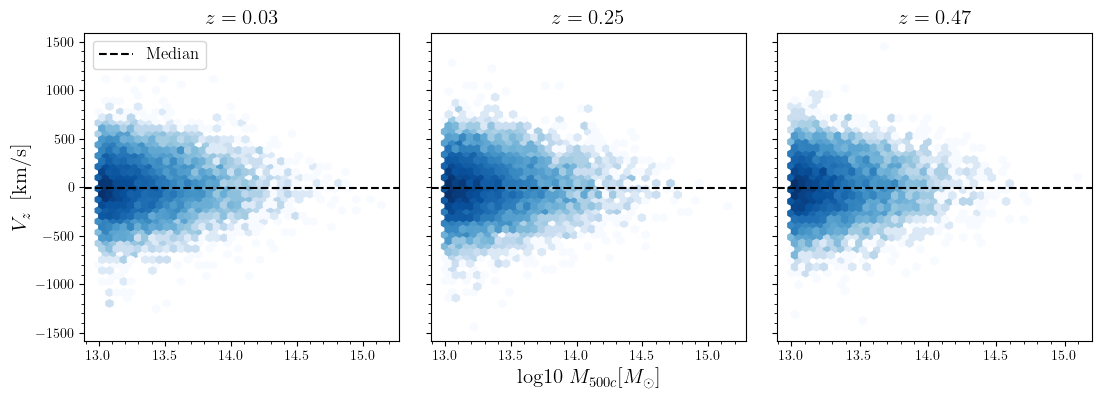

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(13, 4), sharey=True)
plt.subplots_adjust(wspace=0.1)
ax1.hexbin(np.log10(np.exp(df_140.M)),df_140.vz,gridsize=40,cmap='Blues',bins='log',mincnt=1)
ax1.axhline(np.median(df_140.vz),lw=1.5,c='k',ls='--',label='$\\rm Median$')
ax1.set_ylabel('$V_{z}\;\;\mathrm{[km/s]}$',fontsize=15)
ax1.legend(loc='upper left',fontsize=12)
ax1.set_title('$z=0.03$',fontsize=15)

ax2.hexbin(np.log10(np.exp(df_132.M)),df_132.vz,gridsize=40,cmap='Blues',bins='log',mincnt=1)
ax2.axhline(np.median(df_132.vz),lw=1.5,c='k',ls='--',label='$\\rm Median$')
ax2.set_xlabel('$\mathrm{log10}\; M_{500c} [M_\\odot]$',fontsize=15)
ax2.set_title('$z=0.25$',fontsize=15)

ax3.hexbin(np.log10(np.exp(df_096.M)),df_096.vz,gridsize=40,cmap='Blues',bins='log',mincnt=1)
ax3.axhline(np.median(df_096.vz),lw=1.5,c='k',ls='--',label='$\\rm Median$')
ax3.set_title('$z=0.47$',fontsize=15)
plt.savefig('vz_m500c.pdf',dpi=300,bbox_inches='tight')


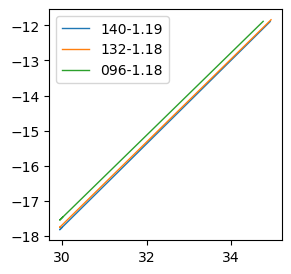

In [26]:
plt.figure(figsize=(3,3))
i = 0
rmse = []
r2 = []
for df in [df_140_m,df_132_m,df_096_m]:
    slope, intercept = np.polyfit(df.M, df.Yksz, 1)
    best_fit_line = slope*df.M+intercept
    rmse.append(mean_squared_error(df.Yksz, best_fit_line,squared=False))
    r2.append(r2_score(df.Yksz, best_fit_line))
    plt.plot(df.M, best_fit_line,linewidth=1,label=f'{snaps[i]}-{slope:.2f}')
    i+=1
plt.legend()

In [28]:
rmse

[1.144756036078561, 1.1447587085569164, 1.1244581168776409]

In [27]:
r2

[0.34849521792878235, 0.3381751247675967, 0.3025901128859617]

In [34]:
def tune_hyperparameters(df, features, target, model_name):
    X = df[features].values.reshape(-1, len(features))
    y = df[target].values

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=df.M_q,random_state=42)

    if model_name == "Linear Regression":
        model = LinearRegression()
        param_grid = {}
    elif model_name == "Random Forest Regression":
        model = RandomForestRegressor()
        param_grid = {
            'n_estimators': [10, 50, 100, 200],
            'max_depth': [ 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif model_name == "Support Vector Regression":
        model = SVR(kernel='linear')
        param_grid = {
            'C': [0.1, 1, 10],
            'epsilon': [0.01, 0.1, 0.2]
        }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=4, scoring='neg_mean_squared_error')

    # Fit the model with grid search
    grid_search.fit(X_train, y_train)

    # Get the best estimator and its hyperparameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    # Make predictions on the test set
    y_pred = best_model.predict(X_test)

    # Evaluate the model
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    return {
        "Best Model": best_model,
        "Best Hyperparameters": best_params,
        "RMSE": rmse,
        "R-squared": r2
    }


In [35]:

results_M = tune_hyperparameters(df_140_m, ['M'], 'Yksz', "Linear Regression")
results_MMstar = tune_hyperparameters(df_140_m, ['M', 'Mstar'], 'Yksz', "Linear Regression")
results_MVz = tune_hyperparameters(df_140_m, ['M', 'Vz'], 'Yksz', "Linear Regression")
results_MMVz = tune_hyperparameters(df_140_m, ['M', 'Mstar', 'Vz'], 'Yksz', "Linear Regression")

# Print and compare the results
for feature_set, result in zip(['M', '[M, Mstar]', '[M, Vz]', '[M, Mstar, Vz]'],
                               [results_M, results_MMstar, results_MVz, results_MMVz]):
    print(f"Results for {feature_set}:")
    print(f"Best Hyperparameters: {result['Best Hyperparameters']}")
    print(f"RMSE: {result['RMSE']:.2f}, R-squared: {result['R-squared']:.2f}")
    print()


Results for M:
Best Hyperparameters: {}
RMSE: 1.19, R-squared: 0.32

Results for [M, Mstar]:
Best Hyperparameters: {}
RMSE: 1.19, R-squared: 0.32

Results for [M, Vz]:
Best Hyperparameters: {}
RMSE: 1.19, R-squared: 0.32

Results for [M, Mstar, Vz]:
Best Hyperparameters: {}
RMSE: 1.19, R-squared: 0.32



In [36]:

results_M = tune_hyperparameters(df_140_m, ['M'], 'Yksz', "Random Forest Regression")
results_MMstar = tune_hyperparameters(df_140_m, ['M', 'Mstar'], 'Yksz', "Random Forest Regression")
results_MVz = tune_hyperparameters(df_140_m, ['M', 'Vz'], 'Yksz', "Random Forest Regression")
results_MMVz = tune_hyperparameters(df_140_m, ['M', 'Mstar', 'Vz'], 'Yksz', "Random Forest Regression")

# Print and compare the results
for feature_set, result in zip(['M', '[M, Mstar]', '[M, Vz]', '[M, Mstar, Vz]'],
                               [results_M, results_MMstar, results_MVz, results_MMVz]):
    print(f"Results for {feature_set}:")
    print(f"Best Hyperparameters: {result['Best Hyperparameters']}")
    print(f"RMSE: {result['RMSE']:.2f}, R-squared: {result['R-squared']:.2f}")
    print()

Results for M:
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
RMSE: 1.21, R-squared: 0.30

Results for [M, Mstar]:
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
RMSE: 1.20, R-squared: 0.31

Results for [M, Vz]:
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
RMSE: 0.93, R-squared: 0.58

Results for [M, Mstar, Vz]:
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
RMSE: 0.92, R-squared: 0.59



In [37]:
results_M = tune_hyperparameters(df_140_m, ['M'], 'Yksz', "Support Vector Regression")
results_MMstar = tune_hyperparameters(df_140_m, ['M', 'Mstar'], 'Yksz', "Support Vector Regression")
results_MVz = tune_hyperparameters(df_140_m, ['M', 'Vz'], 'Yksz', "Support Vector Regression")
results_MMVz = tune_hyperparameters(df_140_m, ['M', 'Mstar', 'Vz'], 'Yksz', "Support Vector Regression")

# Print and compare the results
for feature_set, result in zip(['M', '[M, Mstar]', '[M, Vz]', '[M, Mstar, Vz]'],
                               [results_M, results_MMstar, results_MVz, results_MMVz]):
    print(f"Results for {feature_set}:")
    print(f"Best Hyperparameters: {result['Best Hyperparameters']}")
    print(f"RMSE: {result['RMSE']:.2f}, R-squared: {result['R-squared']:.2f}")
    print()